In [1]:
CODE = '/Users/Lina/Documents/GitHub/habituation'
CODE="./"
#import sys, path, os
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

sys.path.append(CODE)
import system
from calc_util import sliding_maxnorm_ht
from adaint import integrate, default_steps_per_time, integrate2, default_h_max
  

#%% definitions

def control_experiment(f, p, X0, T, Ton, Amin, Amax, Atest=None, tsteps=None, T_tsteps=None, N=20, hmax=0, plot_singlepeaks=False):
    
    # comment
    mys = system.System(f, p, X0, output_var_idx=-1, steps_per_time=100, hmax=hmax)
    mys.T = T
    mys.Ton = Ton
    mys.Amin = Amin
    mys.Amax = Amax
    
    if Atest is None:
        Atest = Amax
    if T_tsteps is None:
        T_tsteps=T
    
    
    ### apply N stimuli
    for i in range(0, N):
        # update initial condition and tvec
        if i==0:
            X = X0
            tvec_ = np.linspace(0, T, T*100)
        else:
            X = singlepeak_[-1, :]
            X[X < 0] = 0.0 
            tvec_ = np.linspace(tvec_[-1], tvec_[-1]+T, T*100)
            
        # integrate single stimulus
        _ , singlepeak_ = mys.apply_singlestimulus(X, T=T, Ton=Ton, Amin=Amin, Amax=Amax, 
                                                  tvec=None)
        if i==0:
            traj = singlepeak_
            tvec = tvec_
        else:    
            traj = np.concatenate([traj, singlepeak_])
            tvec = np.concatenate([tvec, tvec_])
    
    if tsteps is not None:
        ### apply control stimuli after habituation
        
        # this is needed to circumvent an error in integrate_posthabituation_atAmin
        mys.computational_data["habituation_time"] = N*T
        mys.computational_data["habituation_time_step"] = -1
        mys.computational_data['trajectory'] = traj
        
        # let the system recover
        tvec_, recov_ =  mys.integrate_posthabituation_atAmin(tend=1000) #500
        
        mys.computational_data['recovery_trajectory'] = recov_
        
        
        # add stimuli at tsteps
        tend = tvec[-1]
        #start the vector with habituation time and at 0
        tvectest=tvec[-1:]
        trajtest=traj[-1:]
        
        print(tend)
        for i, tstep in enumerate(tsteps):
            
            X = mys.computational_data['recovery_trajectory'][tstep*100,:]
            #print(X)
            X[X<0] = 0.0
            #print("after adjusting", X)
            print("applying perturbation at ", tstep, tstep+tend, tstep+tend-tvectest[0])
            tvec_ = np.linspace(tstep, tstep+T_tsteps, T_tsteps*100) + tend
            #tvec_0= np.linspace(0, T_tsteps, T_tsteps*100) #for integrating, best to do starting from 0

            _ , singlepeak_ = mys.apply_singlestimulus(X, T=T_tsteps, Ton=Ton, Amin=Amin, Amax=Atest, tvec=None)
            #plt.figure()
            #plt.plot(tvec_0,singlepeak_[:,-1])
            #plt.show()

            tvectest = np.concatenate([tvectest, tvec_])
            trajtest = np.concatenate([trajtest, singlepeak_])
            
        
    return [tvec, traj, tvectest, trajtest]


In [2]:
from scipy.signal import argrelmax, find_peaks
import matplotlib as mpl
from matplotlib.gridspec import GridSpec


In [3]:
# CONCATENATED FEEDFORWARD
def f(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)

    return(dI1, dM1, dR1, dI2, dM2, dR2)

p = [ 0.023, 34.44, 17.7071, 0.038241, 57.9236, 1.39117, 0.000534, 
            0.016011, 14.3342,  4.33609, 0.001471, 26.1702, 45.9986, 0.79082] #only rates and ODE parameters
Ton = 1.11
Amin = 0.0

In [6]:
mpl.rcParams["font.size"]=14

600.0
applying perturbation at  15 615.0 15.0
applying perturbation at  75 675.0 75.0
applying perturbation at  120 720.0 120.0
x values at  [  0.          15.          15.01000667 ... 134.97998666 134.98999333
 135.        ]
600.0
applying perturbation at  15 615.0 15.0
applying perturbation at  75 675.0 75.0
applying perturbation at  120 720.0 120.0
x values at  [  0.          15.          15.01000667 ... 134.97998666 134.98999333
 135.        ]
625.0
applying perturbation at  15 640.0 15.0
applying perturbation at  75 700.0 75.0
applying perturbation at  120 745.0 120.0
x values at  [  0.          15.          15.01000667 ... 134.97998666 134.98999333
 135.        ]
375.0
applying perturbation at  15 390.0 15.0
applying perturbation at  75 450.0 75.0
applying perturbation at  120 495.0 120.0
x values at  [  0.          15.          15.01000667 ... 134.97998666 134.98999333
 135.        ]
../../habituation/2023_paper/figs/ConcIFF_commontest1v2.svg
../../habituation/2023_paper/figs/Co

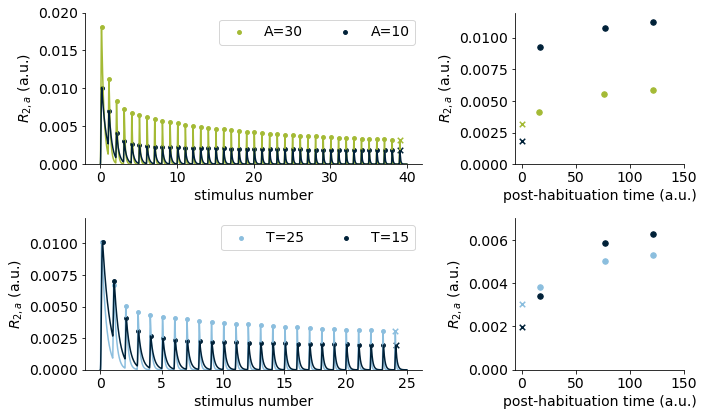

In [14]:
X0 = [0,0,0,0,0,0] 
Amax_low = 10
Amax_high = 30
T_post=15 #period of test stimulus. It matters to define the time at which stimuli are applied
T_slow=25
T_fast=15
tsteps=[1*T_post, 5*T_post, 8*T_post]

darkblue="#002138"
lightblue="#8BBEDE"

lightgreen='#A4BA35'
darkgreen='#002138'

fig = plt.figure(figsize=(10,6))
gs = GridSpec(2, 2, width_ratios=[2, 1])
for case in ["IS","FS"]:
    
    
    
    if case=="IS":
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        labelletter="A"
        value_fix=15 #T 
        idx_fix=3 #keep T fixed to value_fix
        N=40 #number of stimuli to give during the habituation protocol
        options=[[Amax_high, lightgreen], [Amax_low, darkgreen]]
        kwargs={"Atest":Amax_high, "T_tsteps":T_post, "tsteps":tsteps, "N":N, "hmax":0.01}
        idx_=6 #index of Amax_high or Amax_low in the list of parameters to pass to the control_experiment function
        ylim1=0.02
        ylim2=0.012
    else:
        ax1 = fig.add_subplot(gs[2])
        ax2 = fig.add_subplot(gs[3])
        labelletter="T"
        value_fix=10 #Amplitude of stimuli and of common test
        idx_fix=6 #keep Amax fixed to value_fix
        N=25
        options=[[T_slow, lightblue], [T_fast, darkblue]]
        kwargs={"Atest":value_fix, "T_tsteps":T_post,"tsteps":tsteps, "N":N, "hmax":0.01}
        idx_=3 #index of T_slow or T_fast in the list of parameters to pass to the control_experiment function
        ylim1=0.012
        ylim2=0.007
        
    for option in options:
        value,color=option
        
        #define period T to divide the time vector so it is in units of stimulus number
        if case=="IS":
            T_divide=value_fix 
        else:
            T_divide=value
            
        parameter_list=[f, p, X0, 0, Ton, Amin, 0]
        parameter_list[idx_]=value
        parameter_list[idx_fix]=value_fix
        x, y, a, b = control_experiment(*parameter_list, **kwargs)
        
    
        maxima=argrelmax(y[:,-1])[0] #identify the maxima
        levels=y[:,-1][maxima]
        maxima=maxima[np.where(levels>0.001)[0]] #avoid detection of small inaccuracies at the peak valleys
        ax1.plot(x/T_divide,y[:,-1],color=color)
        ax1.scatter((x/T_divide)[maxima][:-1],y[:,-1][maxima][:-1],color=color,s=15, label="%s=%g"%(labelletter,value))
        ax1.scatter((x/T_divide)[maxima][-1],y[:,-1][maxima][-1],color=color,marker="x",s=30) #,facecolor="white")

        #ax2.plot((a-a[0]), b[:,-1], color=color)
        maxima=argrelmax(b[:,-1])[0]
        levels=b[:,-1][maxima]
        maxima=maxima[np.where(levels>0.001)[0]]
        ax2.scatter(0,max(y[-T_divide*100:,-1]),color=color,marker="x",s=30) #,facecolor="white")
        ax2.scatter((a-a[0])[maxima], b[:,-1][maxima], color=color,s=30) #label="S=%g"%Amax_high
        print("x values at ",(a-a[0]))
        #starting point is x[-1], this is t=0
    ax2.set_xticks(np.linspace(0,10*T_post,4))
    ax1.set_xlabel("stimulus number")
    ax1.set_ylabel("$R_{2,a}$ (a.u.)")
    ax1.spines[['right', 'top']].set_visible(False)
    ax1.set_ylim(0,ylim1)
    ax2.set_xlabel("post-habituation time (a.u.)")
    ax2.set_ylabel("$R_{2,a}$ (a.u.)")
    ax2.spines[['right', 'top']].set_visible(False)
    ax2.set_ylim(0,ylim2)
    #ax2.set_ylim(0,ylim1)
    ax1.legend(loc="upper right", ncol=2)
plt.tight_layout()
namesave="../../habituation/2023_paper/figs/ConcIFF_commontest1v2.svg"
print(namesave)
#plt.savefig(namesave,bbox_inches="tight")
namesave=namesave.replace(".svg",".pdf")
print(namesave)
plt.savefig(namesave,bbox_inches="tight")
plt.show()






In [23]:
b

array([[ 0.00000000e+000,  7.26196826e-002,  0.00000000e+000,
         2.44035194e-149,  1.51146285e-002,  2.92012660e-012],
       [ 0.00000000e+000,  4.09200900e-002,  0.00000000e+000,
         0.00000000e+000,  1.47847767e-002,  6.32395297e-018],
       [ 0.00000000e+000,  4.09044403e-002,  0.00000000e+000,
         0.00000000e+000,  1.47845590e-002,  6.27022780e-018],
       ...,
       [ 2.21644670e-135,  8.57725558e-002,  8.74759213e-118,
         1.84329753e-050,  1.42207002e-002,  9.81387058e-006],
       [ 1.56678971e-135,  8.57397400e-002, -2.10658044e-116,
         1.59696045e-050,  1.42204909e-002,  9.73297714e-006],
       [ 1.11078703e-135,  8.57069366e-002, -1.35021123e-116,
         1.38354478e-050,  1.42202815e-002,  9.65275166e-006]])

OTHER/OLD:

applying perturbation at  5 105.0
applying perturbation at  20 120.0
applying perturbation at  40 140.0
applying perturbation at  80 180.0
applying perturbation at  160 260.0
applying perturbation at  5 105.0
applying perturbation at  20 120.0
applying perturbation at  40 140.0
applying perturbation at  80 180.0
applying perturbation at  160 260.0


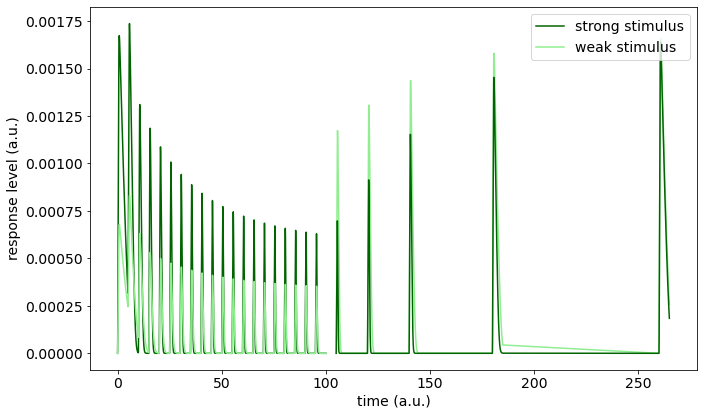

applying perturbation at  5 130.0
applying perturbation at  20 145.0
applying perturbation at  40 165.0
applying perturbation at  80 205.0
applying perturbation at  160 285.0
applying perturbation at  5 255.0
applying perturbation at  20 270.0
applying perturbation at  40 290.0
applying perturbation at  80 330.0
applying perturbation at  160 410.0


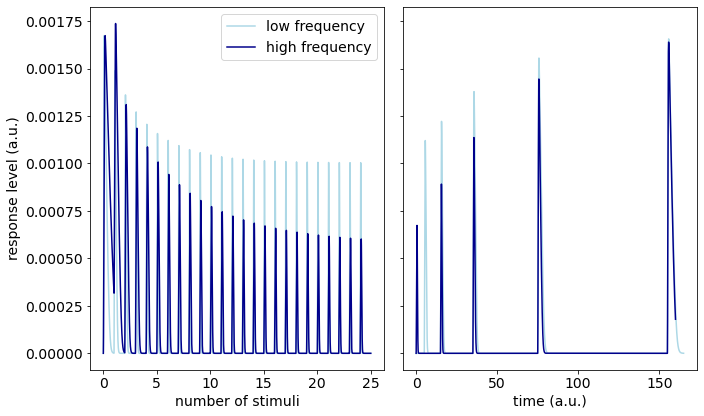

In [155]:
#%% SINGLE IFF MODEL
def f(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1):
    # starting values 
    I1, M1, R1 = X
    # ODEs\n",
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)

    return(dI1, dM1, dR1)

p =[ 0.21431239109526712, 6.847671424297533, 0.009953498338965153 , 0.024876350255001917, 0.011779374058405177, 0.30, 0.0002789402845197418] #only rates and ODE parameters\n",
Ton = 0.5
Amin = 0.0
Amax_low = 4.51
Amax_high = 13.52
Amax = 4.51
T_fast = 5
T_slow = 10
T = 5
X0 = [0,0,0] 

# INTENSITY SENSITIVITY
x1, y1, a1, b1 = control_experiment(f, p, X0, T, Ton, Amin, Amax_high, Atest=Amax_high, tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=20)
x2, y2, a2, b2 = control_experiment(f, p, X0, T, Ton, Amin, Amax_low, Atest=Amax_high, tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=20)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
ax.plot(x1, y1[:,-1], color='darkgreen', label='strong stimulus')
ax.plot(x2, y2[:,-1], color='lightgreen')
ax.plot(a2, b2[:,-1], color='lightgreen', label='weak stimulus')
ax.plot(a1, b1[:,-1], color='darkgreen')
plt.xlabel('time (a.u.)')
ax.set_ylabel('response level (a.u.)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


# FREQUENCY SENSITIVITY
x1, y1, a1, b1 = control_experiment(f, p, X0, T_fast, Ton, Amin, Amax_high, Atest=Amax_high, 
                                    tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=25)
x2, y2, a2, b2 = control_experiment(f, p, X0, T_slow, Ton, Amin, Amax_high, Atest=Amax_high, 
                                    tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=25)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax = axes[0]
ax.plot(x2/T_slow, y2[:,-1], color='lightblue', label='low frequency')
ax.plot(x1/T_fast, y1[:,-1], color='darkblue', label='high frequency')
ax.set_ylabel('response level (a.u.)')
ax.set_xlabel('number of stimuli')
ax.legend(loc='upper right')

ax = axes[1]
ax.plot(a2-a2[0], b2[:,-1], color='lightblue')
ax.plot(a1-a1[0], b1[:,-1], color='darkblue')
plt.xlabel('time (a.u.)')
plt.tight_layout()
plt.show()


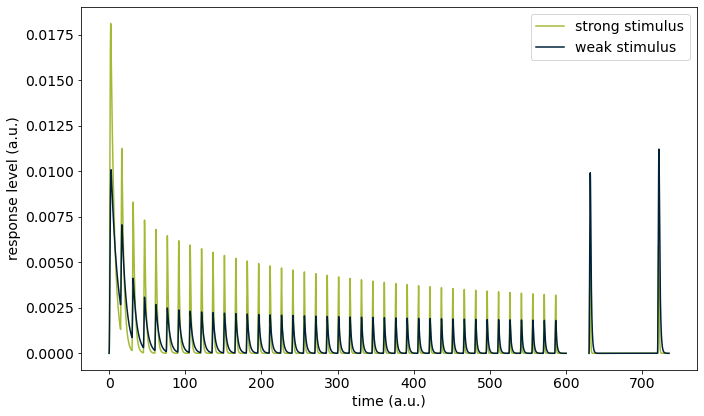

In [159]:
Amax_low = 10
Amax_high = 30
Amax = 10
T_fast = 15

T = 15
X0 = [0,0,0,0,0,0] 

# INTENSITY SENSITIVITY
#x1, y1, a1, b1 = control_experiment(f, p, X0, T, Ton, Amin, Amax_high, Atest=Amax_high, tsteps=[0, T, 4*T, 8*T, 16*T, 32*T], N=40)
#x2, y2, a2, b2 = control_experiment(f, p, X0, T, Ton, Amin, Amax_low, Atest=Amax_high, tsteps=[0, T, 4*T, 8*T, 16*T, 32*T], N=40)
N=40 #ht of the strong
x1, y1, a1, b1 = control_experiment(f, p, X0, T, Ton, Amin, Amax_high, Atest=Amax_high, tsteps=[2*T, 8*T], N=N, hmax=0.01)
x2, y2, a2, b2 = control_experiment(f, p, X0, T, Ton, Amin, Amax_low, Atest=Amax_high, tsteps=[2*T, 8*T], N=N, hmax=0.01)

lightgreen='#A4BA35'
darkgreen='#002138'
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
ax.plot(x1, y1[:,-1], color=lightgreen, label='strong stimulus')
ax.plot(a1, b1[:,-1], color=lightgreen)
ax.plot(x2, y2[:,-1], color=darkgreen)
ax.plot(a2, b2[:,-1], color=darkgreen, label='weak stimulus')

plt.xlabel('time (a.u.)')
ax.set_ylabel('response level (a.u.)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

405.0 655.0


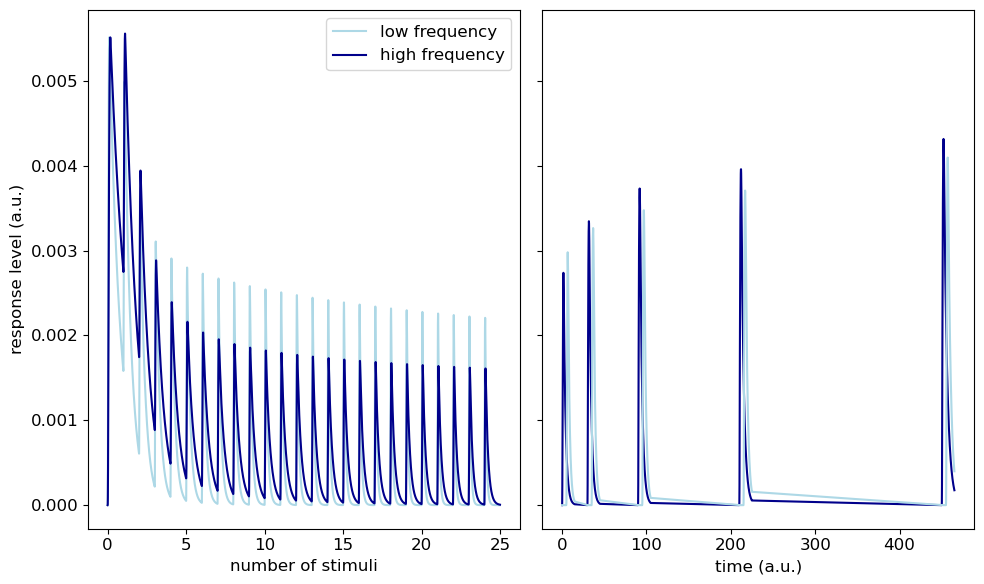

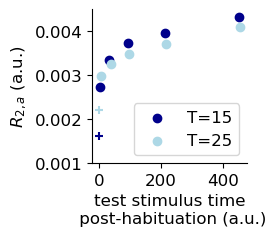

480.0 780.0


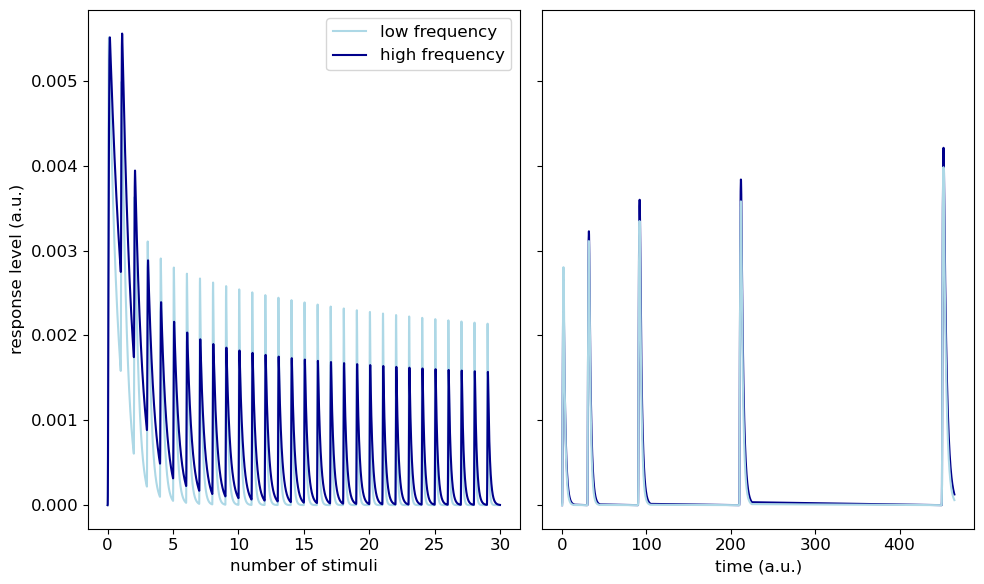

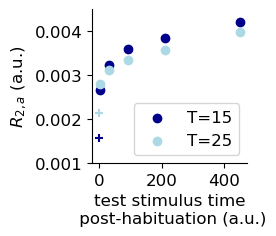

In [13]:
#setting hmax to 0.001 as integration is problematic in some cases
N=30
T_fast=15
Amax_high=10
T=15
T_slow=25
for N in [25, 30]:
    X0 = [0,0,0,0,0,0]

    # FREQUENCY SENSITIVITY
    x1, y1, a1, b1 = control_experiment(f, p, X0, T_fast, Ton, Amin, Amax_high, Atest=Amax_high, 
                                        tsteps=[2*T, 4*T, 8*T, 16*T, 32*T],T_tsteps=T, N=N, hmax=0.01, plot_singlepeaks=False)
    x2, y2, a2, b2 = control_experiment(f, p, X0, T_slow, Ton, Amin, Amax_high, Atest=Amax_high, 
                                        tsteps=[2*T, 4*T, 8*T, 16*T, 32*T],T_tsteps=T, N=N, hmax=0.01, plot_singlepeaks=False)

    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    ax = axes[0]
    ax.plot(x2/T_slow, y2[:,-1], color='lightblue', label='low frequency')
    ax.plot(x1/T_fast, y1[:,-1], color='darkblue', label='high frequency')
    ax.set_ylabel('response level (a.u.)')
    ax.set_xlabel('number of stimuli')
    ax.legend(loc='upper right')

    ax = axes[1]
    print(a1[0], a2[0])
    ax.plot(a1-a1[0], b1[:,-1], color='darkblue')
    ax.plot(a2-a2[0], b2[:,-1], color='lightblue')
    plt.xlabel('time (a.u.)')
    plt.tight_layout()
    plt.show()
    mpl.rcParams["font.size"]=12
    fig,ax=plt.subplots(1,1,figsize=(2,2))
    ax.scatter(0,max(y1[:,-1][-T_fast*100:]),color="darkblue",marker="+")
    maxima=argrelmax(b1[:,-1])
    ax.scatter((a1-a1[0])[maxima], b1[:,-1][maxima], color='darkblue',label="T=%g"%T_fast)
    ax.scatter(0,max(y2[:,-1][-T_slow*100:]),color="lightblue",marker="+")
    maxima=argrelmax(b2[:,-1])
    ax.scatter((a2-a2[0])[maxima], b2[:,-1][maxima], color='lightblue',label="T=%g"%T_slow)
    ax.set_xlabel("test stimulus time\n post-habituation (a.u.)")
    ax.set_ylabel("$R_{2,a}$ (a.u.)")
    ax.legend(loc="lower right")
    ax.set_ylim(0.001,0.0045)
    ax.spines[['right', 'top']].set_visible(False)
    plt.savefig("../../habituation/2023_paper/figs/panels/ConcIFF_FS_posthabtest.svg",bbox_inches="tight")
    plt.show()

There is an important effect in the frequency sensitivity figure. Depending on when the test stimulus is applied, the ratio of response for low vs high freqency is reversed. This is due to the fact that for early test stimuli the first memory, which decays fast, is still present whereas for later stimuli the dynamics is determined by the second memory only. 
I think this is something worth discussing in the paper or SI since it questions the proposed t1-t2 control framework. (On a more general note I am a bit sceptical that the t1-t2 scenario really allows you to measure learning instead of performance. As long as you measure the response rather than the memory/internal state, aren't you always testing performance?)

In order to measure habituation without recovery effects as confounding factor I believe it would be best to apply the test stimulus right after habituation. Do you agree Rosa?